In [1]:
# Install the chainconsumer package if it is not already installed
%pip install 'chainconsumer==0.33.0'

Note: you may need to restart the kernel to use updated packages.


In [2]:
#performing grid scan from A/gamma parameter space to n_T/r parameter space
import sys
import math
import numpy as np
import json
import scipy
import matplotlib.pyplot as plt
import matplotlib
from chainconsumer import ChainConsumer

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

print (sys.version)

%config InlineBackend.figure_format='retina'
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]


In [3]:
#functions
def gev_to_mpci(gev):
    return gev * 1.5626 * 1e38
def hz_to_mpci(hz):
    return hz * 1.0286 * 1e14
def hzi_to_mpc(hzi):
    return hzi / (1.0286 * 1e14)

In [4]:
#setup
#tau: conformal time, a: scale factor, k: wavenumber (comoving)
#using natural units, hbar = c = 1, working in mpc

#constants
c = 3 * 1e8
h_0 = 0.7 
H_0 = h_0 * (1e5 / c) #maggiore, eq 17.5. units: mpc^-1

Omega_R = 4.184 * 1e-5 * (h_0 ** -2) #maggiore 17.79
Omega_M = 0.3 #maggiore 17.80
Omega_L = 1 - Omega_R - Omega_M #see section below maggiore 17.80
# Lambda = (1 / 3.24078) * 1e-6 #from wikipedia (converted), units: mpc^-2

#RD/MD equilibrium, maggiore values
a_eq = Omega_R / Omega_M #maggiore 17.83
k_eq = 0.073 * Omega_M * h_0**2 #from papers
tau_0 = 0.879 * 2 / (H_0 * math.sqrt(Omega_M))
tau_star = (2 * math.sqrt(Omega_R)) / (H_0 * Omega_M)
tau_eq = (math.sqrt(2) - 1) * tau_star
tau_dec = 2.55

#MD/lambdaD equilibrium (?)
a_eq2 = (Omega_M / Omega_L) ** (1/3)

#inflationary constants (see vagnozzi paper)
A_s = 2.1e-9
yr = hzi_to_mpc(1 / (3.17e-8))
kstar = 0.05 #mpc^-1
fstar = hz_to_mpci(7.7e-17) # = k * c / (2pi)

In [5]:
print(k_eq)

0.010730999999999997


In [6]:
datapath = './nanograv/figure1_data/'
hd_chain = np.load(datapath + 'nano15_hd_chain_long_050523.npy')

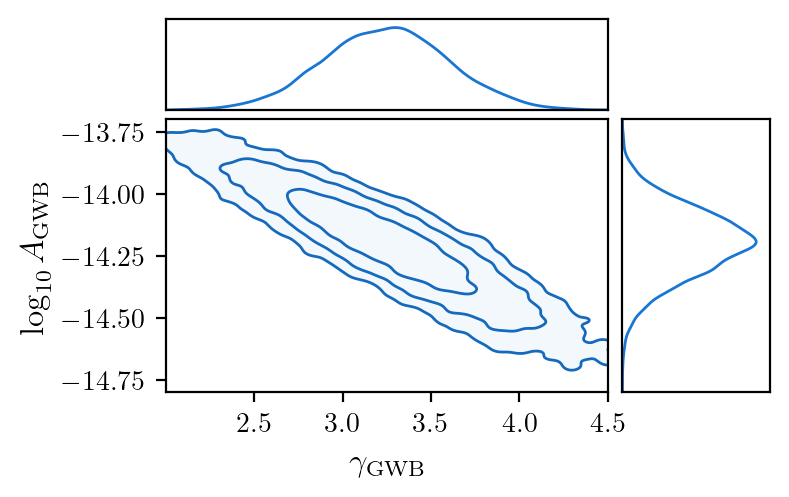

In [7]:
from matplotlib.ticker import FormatStrFormatter

labs = [r'$\gamma_\mathrm{GWB}$', 
        r'$\log_{10}A_\mathrm{GWB}$']

c = ChainConsumer()
c.add_chain(hd_chain,
          weights=None,
          parameters=labs, 
          zorder=2, name='$f_\mathrm{ref}$ = $1\,\, \mathrm{yr}^{-1}\quad 32\,\,\mathrm{nHz}$')

c.configure(usetex=True, 
            bar_shade=False,
            colors='blue',
           linestyles='solid',
           linewidths=1.0,
           shade=True, 
            shade_alpha=0.05,
            summary=False,
            smooth=50.0,
            diagonal_tick_labels=False,
           legend_kwargs={'loc':(0.03,0.05), 'handlelength':0, 
                          'markerfirst':True, 'fontsize':'small'},
           sigmas=[0,1,2,3], 
            shade_gradient=0.0)

fig = c.plotter.plot(
                     extents=[(2, 4.5), (-14.8, -13.7)],
                    figsize=(3.5503666805036667, 2.1942472810764047)) 

plt.show()

In [8]:
def conf_ellip(mu, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    sigma_x = np.sqrt(cov[0, 0])
    sigma_y = np.sqrt(cov[1, 1])
    pearson = cov[0, 1] / (sigma_x * sigma_y)
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    scale_x = sigma_x * n_std
    mean_x = mu[0]

    scale_y = sigma_y * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    ax.set_xlim([mean_x - sigma_x * 3, mean_x + sigma_x * 3])
    ax.set_ylim([mean_y - sigma_y * 3, mean_y + sigma_y * 3])   
     
    ax.add_patch(ellipse)

def ellipse_contains(mu, cov, n_std, pt):
    m_x, m_y = mu[0], mu[1]
    s_x = np.sqrt(cov[0, 0])
    s_y = np.sqrt(cov[1, 1])
    p = cov[0, 1] / (s_x * s_y)
    x, y = pt[0], pt[1]
    lhs = (1 - p**2) * (s_x**2) * (s_y**2)*(n_std**2)
    rhs = (s_y * (x - m_x))**2 + (s_x * (y - m_y))**2 - 2 * p * s_x * s_y * (x - m_x) * (y - m_y)
    return (rhs <= lhs)

#generate points within n_std ellipse, w/ num_pts along one axis
def ellipse_scan(mu, cov, n_std, num_pts):
    s_x = np.sqrt(cov[0, 0])
    s_y = np.sqrt(cov[1, 1])
    pearson = cov[0, 1] / (s_x * s_y)

    logA, gamma = np.meshgrid(
        np.linspace(mu[0] - (n_std + 1)*s_x, mu[0] + (n_std + 1)*s_x, num_pts),
        np.linspace(mu[1] - (n_std + 1)*s_y, mu[1] + (n_std + 1)*s_y, num_pts))
    grid_pairs = list(zip(np.ravel(logA), np.ravel(gamma)))

    ellip_pairs = list(filter(lambda pt: ellipse_contains(mu, cov, n_std, pt), grid_pairs))
    return np.array(ellip_pairs)


In [9]:
mu1 = np.mean(hd_chain, axis=0)
cov1 = np.cov([hd_chain[:,0], hd_chain[:, 1]])

print(mu1)
print(cov1)

mu15 = np.array([3.2, -14.2])
cov15 = np.array([[0.127, -0.045], [-0.045, 0.021]])

[  3.24561639 -14.19797796]
[[ 0.12879073 -0.04489819]
 [-0.04489819  0.01912812]]


In [10]:
one_val = np.sqrt(-2 * np.log(1 - 0.683))
two_val = np.sqrt(-2 * np.log(1 - 0.954))
three_val = np.sqrt(-2 * np.log(1 - 0.997))
print(one_val, two_val, three_val)

1.5158189239515758 2.481577676597306 3.408560690471574


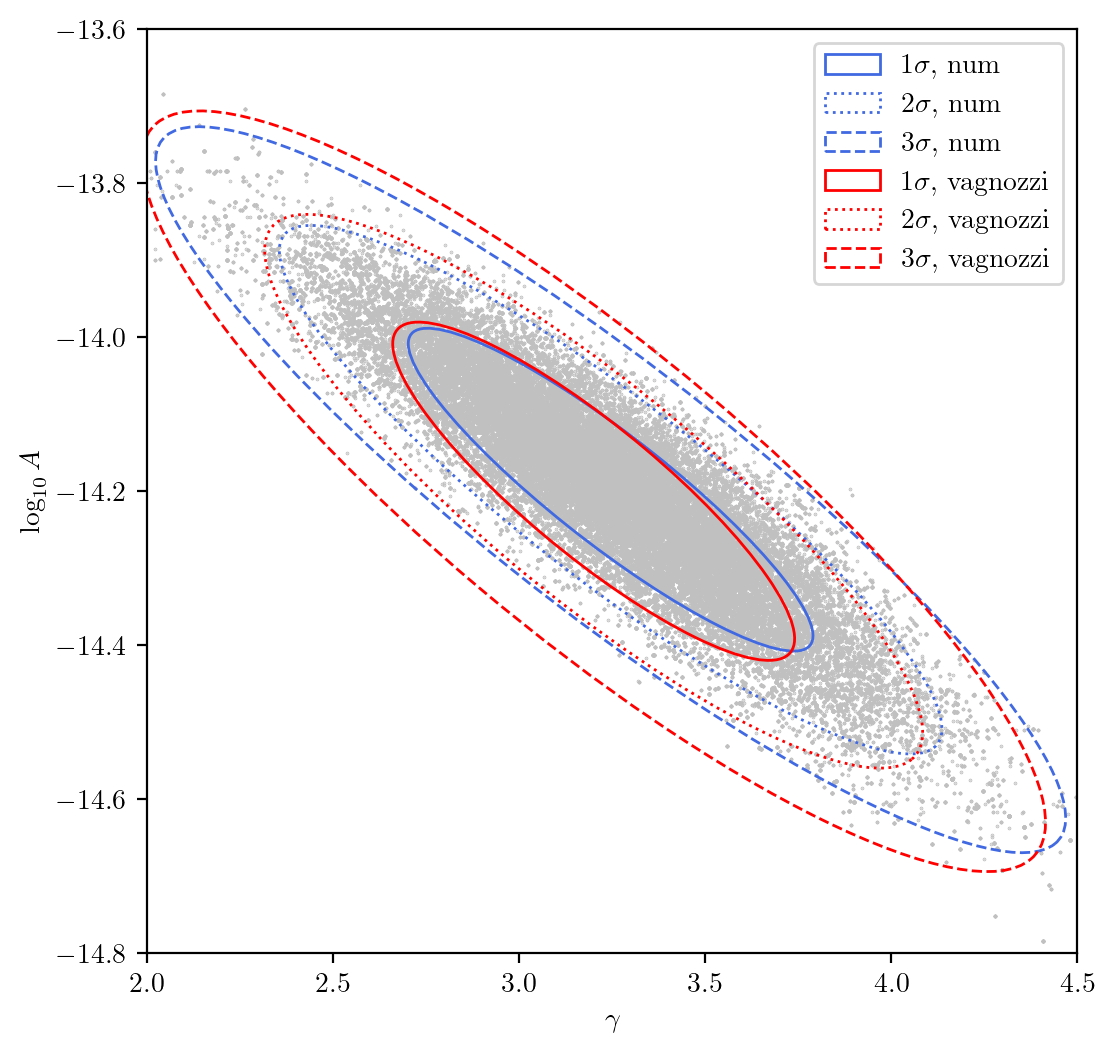

In [11]:
fig, axs = plt.subplots(1, 1)

conf_ellip(mu1, cov1, axs, one_val, edgecolor = 'royalblue', ls = "-", zorder = 1, label = r'$1 \sigma$, num')
conf_ellip(mu1, cov1, axs, two_val, edgecolor = 'royalblue', ls = ":", zorder = 1, label = r'$2 \sigma$, num')
conf_ellip(mu1, cov1, axs, three_val, edgecolor = 'royalblue', ls = "--", zorder = 1, label = r'$3 \sigma$, num')

conf_ellip(mu15, cov15, axs, one_val, edgecolor = 'red', ls = "-", zorder = 1, label = r'$1 \sigma$, vagnozzi')
conf_ellip(mu15, cov15, axs, two_val, edgecolor = 'red', ls = ":", zorder = 1, label = r'$2 \sigma$, vagnozzi')
conf_ellip(mu15, cov15, axs, three_val, edgecolor = 'red', ls = "--", zorder = 1, label = r'$3 \sigma$, vagnozzi')


axs.scatter(hd_chain[:,0], hd_chain[:, 1], s = 0.1, zorder = 0, color = "silver")

plt.xlim((2, 4.5))
plt.ylim((-14.8, -13.6))

fig.set_figwidth(6)
fig.set_figheight(6)

plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\log_{10} A$")
plt.legend()
plt.show()

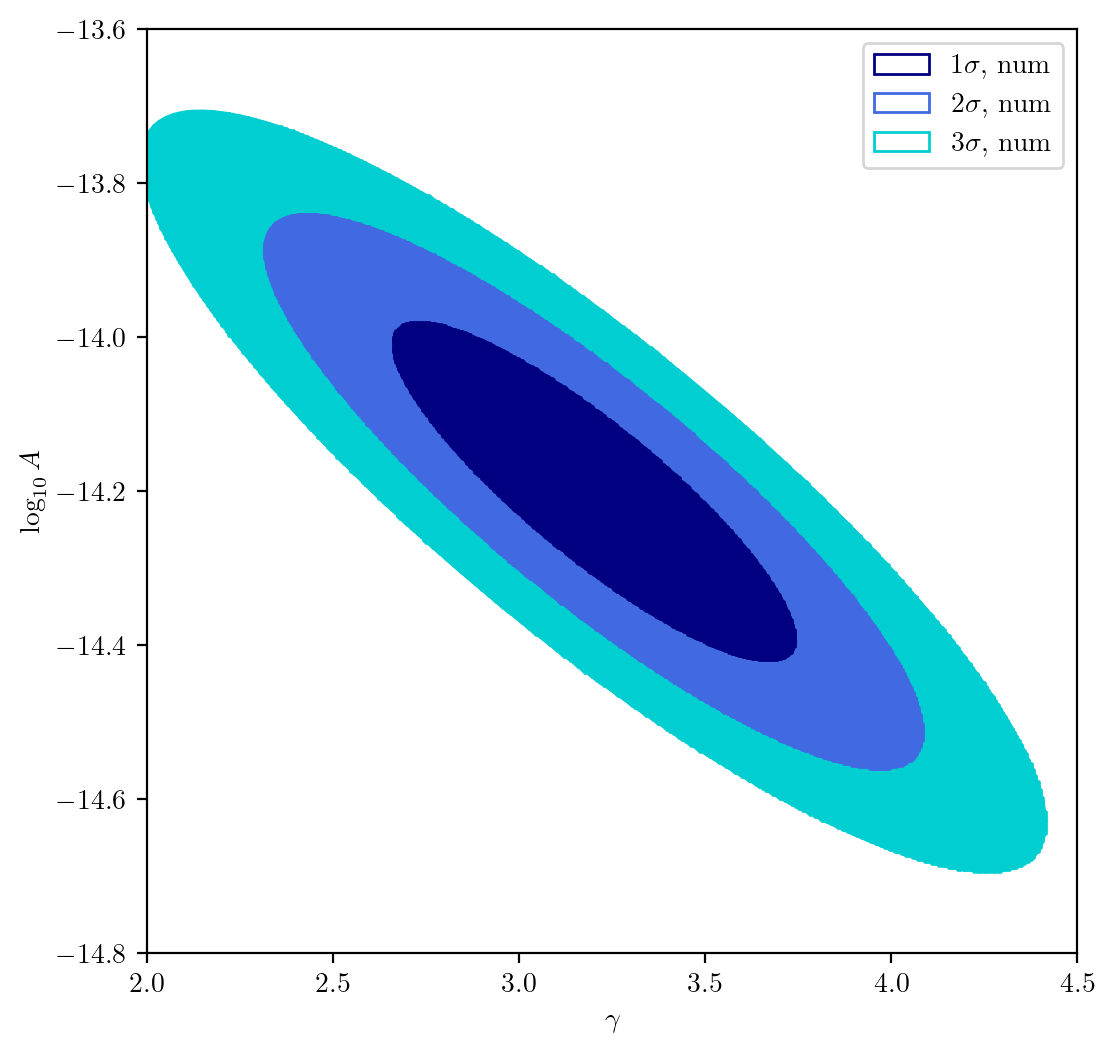

In [12]:
#grid scan
fig, axs = plt.subplots(1, 1)

dim_pts = 500

#15 for vagnozzi, 1 for my num
mu_curr = mu15
cov_curr = cov15


conf_ellip(mu_curr, cov_curr, axs, one_val, edgecolor = 'navy', ls = "-", label = r'$1 \sigma$, num')
one_pairs = ellipse_scan(mu_curr, cov_curr, one_val, dim_pts)
axs.scatter(one_pairs[:,0], one_pairs[:,1], s = 0.5, c = 'navy', zorder = 2)

conf_ellip(mu_curr, cov_curr, axs, two_val, edgecolor = 'royalblue', ls = "-", label = r'$2 \sigma$, num')
two_pairs = ellipse_scan(mu_curr, cov_curr, two_val, dim_pts)
axs.scatter(two_pairs[:,0], two_pairs[:,1], s = 0.5, c = 'royalblue', zorder = 1)

conf_ellip(mu_curr, cov_curr, axs, three_val, edgecolor = 'darkturquoise', ls = "-", label = r'$3 \sigma$, num')
three_pairs = ellipse_scan(mu_curr, cov_curr, three_val, dim_pts)
axs.scatter(three_pairs[:,0], three_pairs[:,1], s = 0.5, c = 'darkturquoise', zorder = 0)

plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\log_{10} A$")

plt.xlim((2, 4.5))
plt.ylim((-14.8, -13.6))

fig.set_figwidth(6)
fig.set_figheight(6)

plt.legend()
plt.show()

In [48]:
def pta_to_infl(pt, s1): #convert from (gamma, log A) to (n_T, log r)
    g = pt[0] #gamma
    A = 10**pt[1]
    n_T = 5 - g
    C = (Omega_M / Omega_L) * (yr / (np.pi * tau_0**2 * k_eq)) * np.sqrt(9 * s1 * A_s / 8)
    r = (A / C)**2 * (fstar * yr)**n_T
    return [n_T, np.log10(r)]

def infl_to_pta(pt, s1): #convert from (n_T, log r) to (gamma, log A)
    n_T, r = pt[0], 10**pt[1]
    g = 5 - n_T
    C = (Omega_M / Omega_L) * (yr / (np.pi * tau_0**2 * k_eq)) * np.sqrt(9 * s1 * A_s / 8)
    A = C * (fstar * yr)**(-n_T / 2) * np.sqrt(r)
    return [g, np.log10(A)]

def tst_pta_to_infl(pt):
    g = pt[0] #gamma
    A = 10**pt[1]
    n_T = 5 - g
    r = (A / (0.875 * 10**(4.3*n_T - 18)))**2
    return [n_T, np.log10(r)]

In [46]:
s1_GR = 5/8 #for vagnozzi
# s1_GR = 5/2 #from turner, kind of
# s1_GR = 4.1576 #from my numerics
s1_MG = 292.51 #from my numerics

GR_one_pairs_infl = np.array([pta_to_infl(pt, s1_GR) for pt in one_pairs])
GR_two_pairs_infl = np.array([pta_to_infl(pt, s1_GR) for pt in two_pairs])
GR_three_pairs_infl = np.array([pta_to_infl(pt, s1_GR) for pt in three_pairs])

MG_one_pairs_infl = np.array([pta_to_infl(pt, s1_MG) for pt in one_pairs])
MG_two_pairs_infl = np.array([pta_to_infl(pt, s1_MG) for pt in two_pairs])
MG_three_pairs_infl = np.array([pta_to_infl(pt, s1_MG) for pt in three_pairs])

In [15]:
# s1_GR = 5/8 #for vagnozzi
# # s1_GR = 5/2 #from turner, kind of
# # s1_GR = 4.1576 #from my numerics
# s1_MG = 292.51 #from my numerics

# GR_one_pairs_infl = np.array([pta_to_infl(pt, s1_GR) for pt in one_pairs])
# GR_two_pairs_infl = np.array([pta_to_infl(pt, s1_GR) for pt in two_pairs])
# GR_three_pairs_infl = np.array([pta_to_infl(pt, s1_GR) for pt in three_pairs])

# MG_one_pairs_infl = np.array([tst_pta_to_infl(pt) for pt in one_pairs])
# MG_two_pairs_infl = np.array([tst_pta_to_infl(pt) for pt in two_pairs])
# MG_three_pairs_infl = np.array([tst_pta_to_infl(pt) for pt in three_pairs])

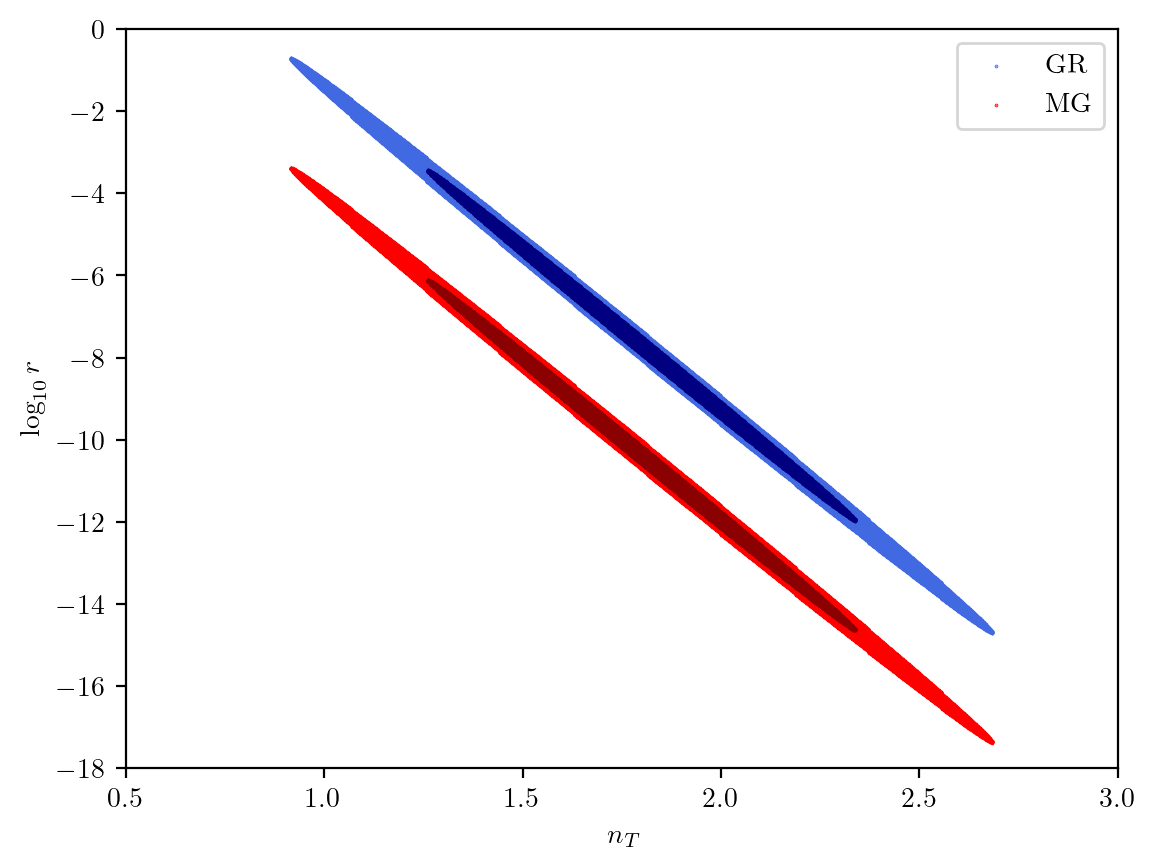

In [47]:
plt.scatter(GR_one_pairs_infl[:, 0], GR_one_pairs_infl[:, 1], s = 0.1, c = "navy", zorder = 2)
plt.scatter(GR_two_pairs_infl[:, 0], GR_two_pairs_infl[:, 1], s = 0.1, c = "royalblue", zorder = 1, label = "GR")
# plt.scatter(GR_three_pairs_infl[:, 0], GR_three_pairs_infl[:, 1], s = 0.1, c = "darkturquoise", zorder = 0)

plt.scatter(MG_one_pairs_infl[:, 0], MG_one_pairs_infl[:, 1], s = 0.1, c = "darkred", zorder = 2)
plt.scatter(MG_two_pairs_infl[:, 0], MG_two_pairs_infl[:, 1], s = 0.1, c = "red", zorder = 1, label = "MG")
# plt.scatter(MG_three_pairs_infl[:, 0], MG_three_pairs_infl[:, 1], s = 0.1, c = "lightcoral", zorder = 0)

plt.xlim((0.5, 3))
plt.ylim((-18, 0))

plt.xlabel(r"$n_T$")
plt.ylabel(r"$\log_{10} r$")
plt.legend()
plt.show()

In [17]:
#emcee test
import emcee

In [62]:
def log_prob(x, mu, cov, s1):
    x2 = infl_to_pta(x, s1)
    diff = x2 - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

ndim = 2
nwalkers = 32

p0 = np.random.rand(nwalkers, ndim)
GR_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[mu15, cov15, s1_GR])
MG_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[mu15, cov15, s1_MG])

#burn-in
GR_state = GR_sampler.run_mcmc(p0, 1000)
GR_sampler.reset()
MG_state = MG_sampler.run_mcmc(p0, 1000)
MG_sampler.reset()

GR_sampler.run_mcmc(GR_state, 10000)
MG_sampler.run_mcmc(MG_state, 10000)

State([[  2.1063726  -12.67901999]
 [  1.66900232  -9.41127672]
 [  2.12747643 -12.87850458]
 [  2.15160761 -13.0955439 ]
 [  1.41062121  -7.34442057]
 [  1.08791502  -4.85516984]
 [  2.10720155 -12.84587586]
 [  1.80986243 -10.46641754]
 [  2.04610021 -12.28171646]
 [  1.77322714 -10.11242004]
 [  1.54119988  -8.46972868]
 [  1.69989312  -9.58705432]
 [  1.71321809  -9.70706487]
 [  1.07931602  -4.63980517]
 [  2.38871927 -14.97999323]
 [  1.63570759  -9.06181877]
 [  1.95395584 -11.48097913]
 [  1.35711847  -6.71066461]
 [  1.80594262 -10.45531442]
 [  1.96119794 -11.58519739]
 [  2.13144736 -12.66802938]
 [  2.41751094 -15.45847698]
 [  1.42568265  -7.35602039]
 [  1.65704079  -9.1104774 ]
 [  1.48586725  -8.01759796]
 [  1.65159757  -9.33235445]
 [  1.45523815  -7.68987768]
 [  2.34487826 -14.68327879]
 [  2.67707881 -17.35384075]
 [  1.64358297  -8.97206841]
 [  1.44400821  -7.60397531]
 [  1.55762611  -8.67418047]], log_prob=[-0.70748297 -0.1999166  -0.59778466 -0.56991845 -0.656

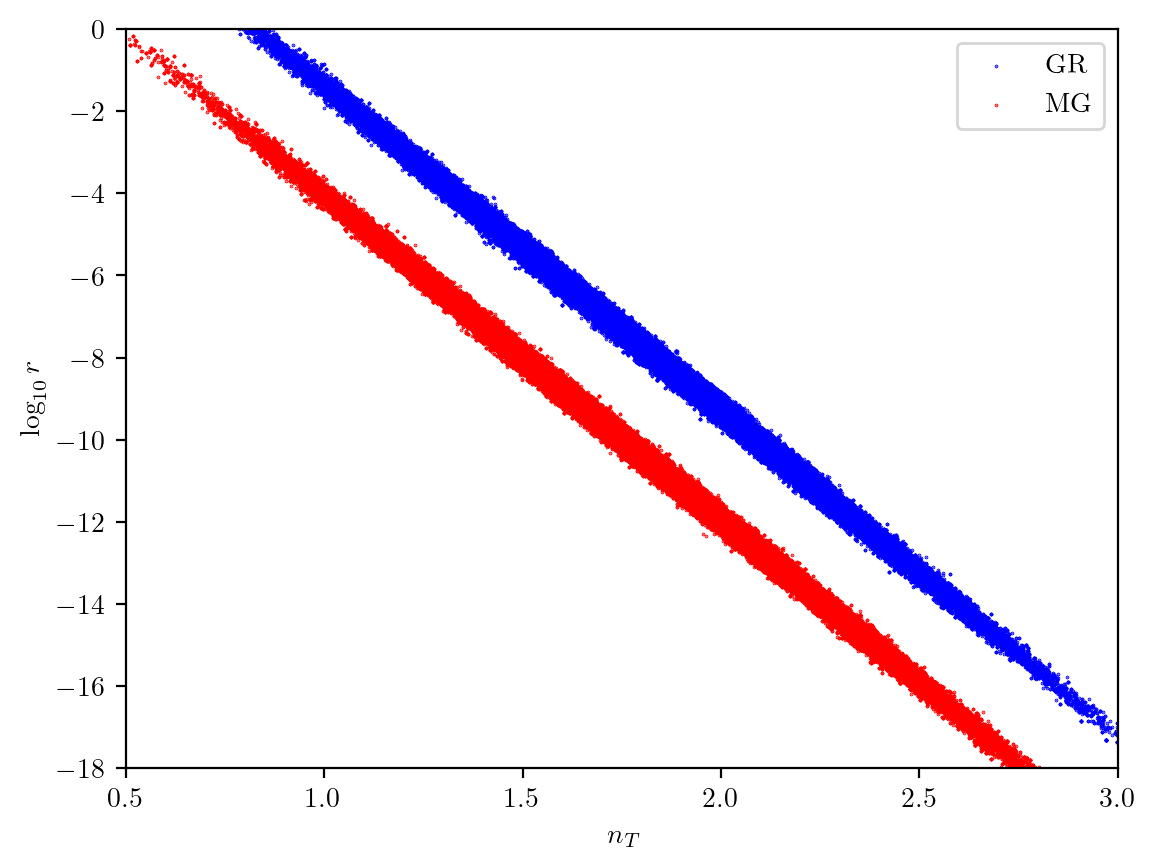

In [63]:
GR_samples = GR_sampler.get_chain(flat=True)
MG_samples = MG_sampler.get_chain(flat=True)

plt.scatter(GR_samples[:, 0], GR_samples[:, 1], s = 0.1, c = "b", label = "GR")
plt.scatter(MG_samples[:, 0], MG_samples[:, 1], s = 0.1, c = "r", label = "MG")

plt.xlim((0.5, 3))
plt.ylim((-18, 0))

plt.xlabel(r"$n_T$")
plt.ylabel(r"$\log_{10} r$")
plt.legend()
# plt.hist(samples[:, 0], 100, color="k", histtype="step")
# plt.xlabel(r"$\theta_1$")
# plt.ylabel(r"$p(\theta_1)$")
# plt.gca().set_yticks([]);